In [2]:

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Traffic_Jams.csv')
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,13,2,2,24,41,normal
1,12:15:00 AM,10,Tuesday,14,1,1,36,52,normal
2,12:30:00 AM,10,Tuesday,10,2,2,32,46,normal
3,12:45:00 AM,10,Tuesday,10,2,2,36,50,normal
4,1:00:00 AM,10,Tuesday,11,2,1,34,48,normal


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6324 entries, 0 to 6323
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               6324 non-null   object
 1   Date               6324 non-null   int64 
 2   Day of the week    6324 non-null   object
 3   CarCount           6324 non-null   int64 
 4   BikeCount          6324 non-null   int64 
 5   BusCount           6324 non-null   int64 
 6   TruckCount         6324 non-null   int64 
 7   Total              6324 non-null   int64 
 8   Traffic Situation  6324 non-null   object
dtypes: int64(6), object(3)
memory usage: 444.8+ KB


In [4]:
#filter data
filter_data = df[df['Day of the week'] == 'Tuesday']
filter_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1011 entries, 0 to 6298
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               1011 non-null   object
 1   Date               1011 non-null   int64 
 2   Day of the week    1011 non-null   object
 3   CarCount           1011 non-null   int64 
 4   BikeCount          1011 non-null   int64 
 5   BusCount           1011 non-null   int64 
 6   TruckCount         1011 non-null   int64 
 7   Total              1011 non-null   int64 
 8   Traffic Situation  1011 non-null   object
dtypes: int64(6), object(3)
memory usage: 79.0+ KB


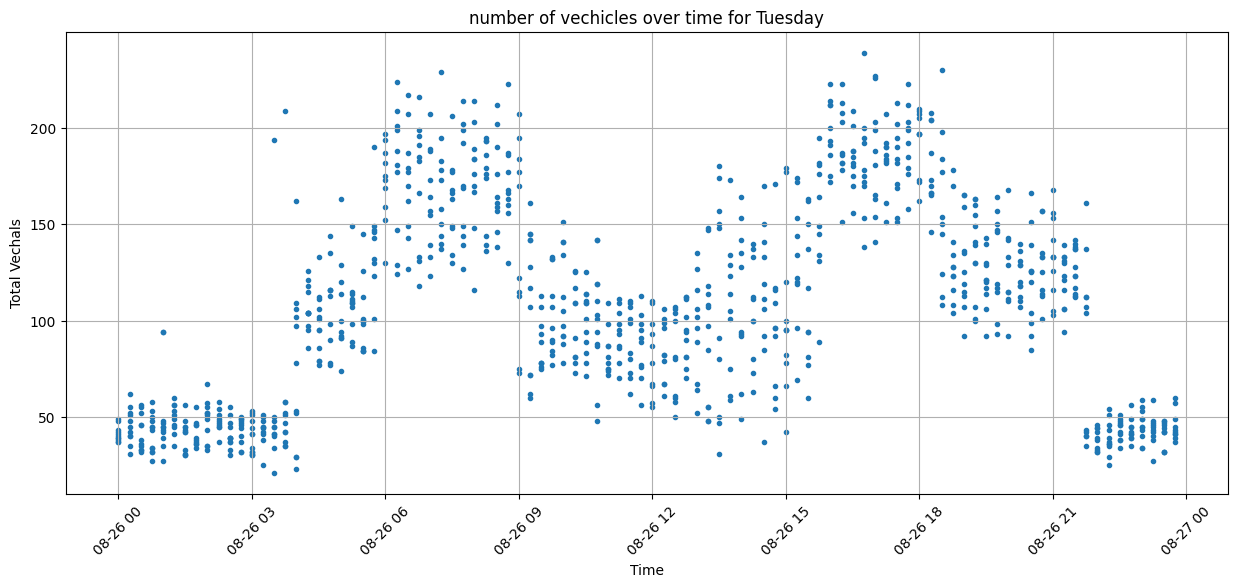

In [5]:
filter_data['Time'] = pd.to_datetime(filter_data['Time'])

plt.figure(figsize=(15, 6))
plt.scatter(filter_data['Time'], filter_data['Total'], marker='.')
plt.title('number of vechicles over time for Tuesday')
plt.xlabel('Time')
plt.ylabel('Total Vechals')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [7]:
new_df = filter_data.reset_index()['Total']

In [11]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))
scaled_data

array([[0.09174312],
       [0.14220183],
       [0.1146789 ],
       ...,
       [0.56880734],
       [0.55504587],
       [0.44495413]])

In [8]:
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [9]:
n_past = 12

# Prepare sequences for RNN
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#modling RNN

In [11]:
model = Sequential()

model.add(SimpleRNN(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=30, return_sequences=True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=30))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 12, 30)              │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 12, 30)              │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 30)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,651 (18.17 KB)

 Trainable params: 4,651 (18.17 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:

checkpoints = ModelCheckpoint(filepath = 'my_weights.keras', save_best_only = True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(X_train, y_train,
          validation_data=(X_test,y_test),
          epochs=20,
          batch_size=64,
          verbose=1,
          callbacks= [checkpoints, early_stopping])

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0524 - val_loss: 0.0296
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0471 - val_loss: 0.0272
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0401 - val_loss: 0.0267
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0479 - val_loss: 0.0270
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0455 - val_loss: 0.0272
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0402 - val_loss: 0.0290
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0437 - val_loss: 0.0269
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0371 - val_loss: 0.0277
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0426 - val_loss: 0.0281
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0359 - val_loss: 0.0274
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0392 - val_loss: 0.0271
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [14]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [15]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [16]:
# Calculate train data RMSE for RNN epochs 10
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

117.68048946078952
118.95028385413299


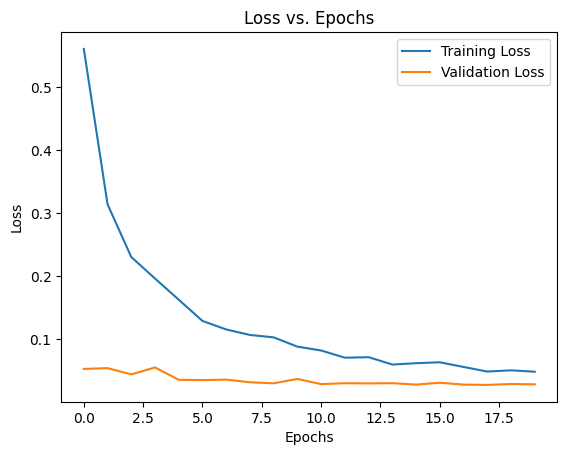

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

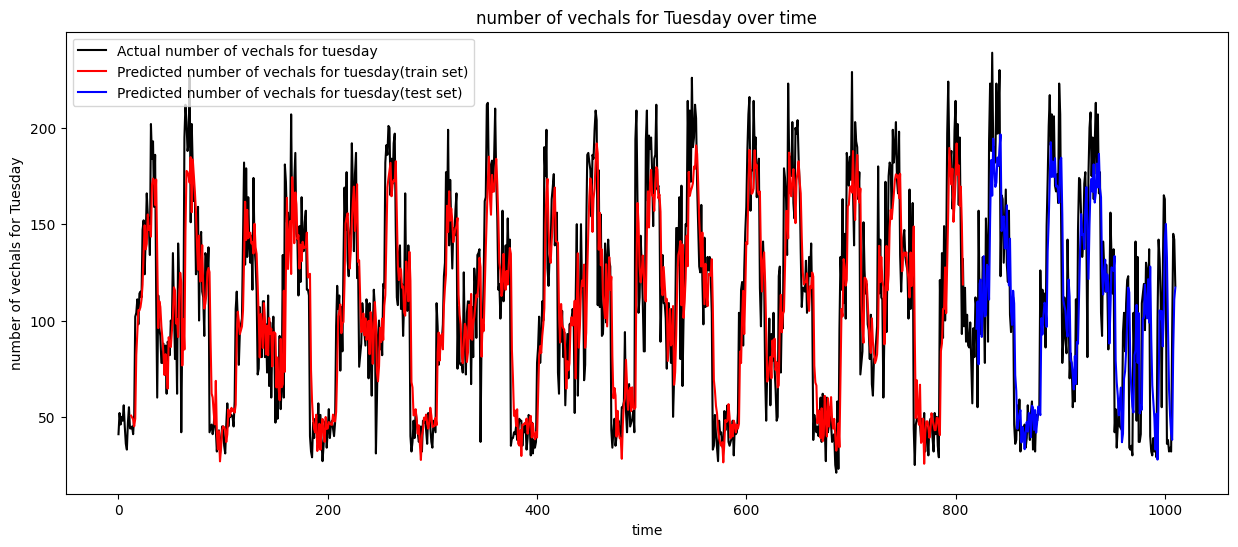

In [38]:
new_df_float = new_df.astype(float)
# Set the number of previous time steps to consider for plotting
look_back = 12

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(new_df_float, dtype=float)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict.flatten()

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(new_df_float)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(new_df_float) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict.flatten()

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual number of vechals for tuesday")
plt.plot(trainPredictPlot, color='red', label=f"Predicted number of vechals for tuesday(train set)")
plt.plot(testPredictPlot, color='blue', label=f"Predicted number of vechals for tuesday(test set)")

plt.title(f"number of vechals for Tuesday over time")
plt.xlabel("time")
plt.ylabel(f"number of vechals for Tuesday")
plt.legend()
plt.show()

#modeling LSTM

In [34]:
from keras.layers import Dense, LSTM, Dropout, GRU

regressor = Sequential()

#first LSTM layer
regressor.add(LSTM(units=30, return_sequences =True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

history2 = regressor.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.1369 - val_loss: 0.0494
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0432 - val_loss: 0.0469
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0392 - val_loss: 0.0439
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0368 - val_loss: 0.0412
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0335 - val_loss: 0.0396
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0332 - val_loss: 0.0385
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0307 - val_loss: 0.0351
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0237 - val_loss: 0.0344
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0272 - val_loss: 0.0347
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0284 - val_loss: 0.0356


In [20]:

train_predict2=regressor.predict(X_train)
test_predict2=regressor.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [21]:
train_predict2=scaler.inverse_transform(train_predict2)
test_predict2=scaler.inverse_transform(test_predict2)

In [22]:
# Calculate train data RMSE for LSTM epochs 10
print(math.sqrt(mean_squared_error(y_train,train_predict2)))
print(math.sqrt(mean_squared_error(y_test,test_predict2)))

109.38395480208291
110.85583987304193


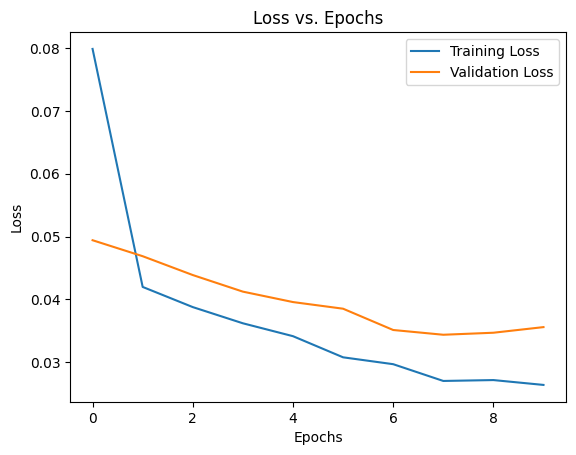

In [35]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#modling GRU

In [23]:

from keras.layers import Dense, LSTM, Dropout, GRU

regressorGRU = Sequential()

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=30, activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(Dense(units=1))

regressorGRU.compile(optimizer='adam',loss='mean_squared_error')

regressorGRU.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1347
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0431
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0349
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0303
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0317
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0288
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0258
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0277
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0264
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0259


In [24]:
train_predict3=regressorGRU.predict(X_train)
test_predict3=regressorGRU.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [25]:
train_predict3=scaler.inverse_transform(train_predict3)
test_predict3=scaler.inverse_transform(test_predict3)

In [26]:
# Calculate train data RMSE for GRU epochs 10
print(math.sqrt(mean_squared_error(y_train,train_predict3)))
print(math.sqrt(mean_squared_error(y_test,test_predict3)))

99.68062019027278
101.11846065452582
